# 11.Long Short Term Memory Algorithm (LSTM)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:

df = pd.read_csv('tesla.csv')
df

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...,...
1687,3/13/2017,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
1688,3/14/2017,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
1689,3/15/2017,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
1690,3/16/2017,262.399994,265.750000,259.059998,262.049988,7100400,262.049988


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df

,Date,Open,High,Low,Close,Volume,Adj Close
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300,23.889999
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100,23.830000
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800,21.959999
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800,19.200001
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900,16.110001
...,...,...,...,...,...,...,...
1687,2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700,246.169998
1688,2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500,258.000000
1689,2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600,255.729996
1690,2017-03-16,262.399994,265.750000,259.059998,262.049988,7100400,262.049988


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1692 non-null   datetime64[ns]
 1   Open       1692 non-null   float64       
 2   High       1692 non-null   float64       
 3   Low        1692 non-null   float64       
 4   Close      1692 non-null   float64       
 5   Volume     1692 non-null   int64         
 6   Adj Close  1692 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 92.7 KB


In [7]:
df = df.sort_values(by='Date', ascending=True)

In [8]:
df = df.drop(['Adj Close'],axis=1)

In [9]:
df

,Date,Open,High,Low,Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,6866900
...,...,...,...,...,...,...
1687,2017-03-13,244.820007,246.850006,242.779999,246.169998,3010700
1688,2017-03-14,246.110001,258.119995,246.020004,258.000000,7575500
1689,2017-03-15,257.000000,261.000000,254.270004,255.729996,4816600
1690,2017-03-16,262.399994,265.750000,259.059998,262.049988,7100400


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['Open','High','Low','Close','Volume']] = scaler.fit_transform(df[['Open','High','Low','Close','Volume']])

In [11]:
n_steps = 45 
# Create sequences of input-output pairs
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i+n_steps, 1:].values)  # Input features (excluding 'Date' column)
        y.append(data.iloc[i+n_steps, 4])            # Target variable ('Close' price)
    return np.array(X), np.array(y)

X, y = create_sequences(df, n_steps)



In [12]:
# Split the dataset into training and testing sets
split_ratio = 0.8  
split_index = int(split_ratio * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [13]:
X_train.shape

(1317, 45, 5)

In [14]:
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(n_steps, 5)),
    Dense(units=1)  # Output layer with 1 neuron for regression task
])

C:\Users\abins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.compile(optimizer='adam', loss='mse')

In [16]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1592
Epoch 2/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024
Epoch 3/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011
Epoch 4/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7905e-04
Epoch 5/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4626e-04
Epoch 6/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3503e-04
Epoch 7/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.1679e-04
Epoch 8/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.8811e-04
Epoch 9/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.1701e-04
Epoch 10/10
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2531e-04


In [17]:
y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


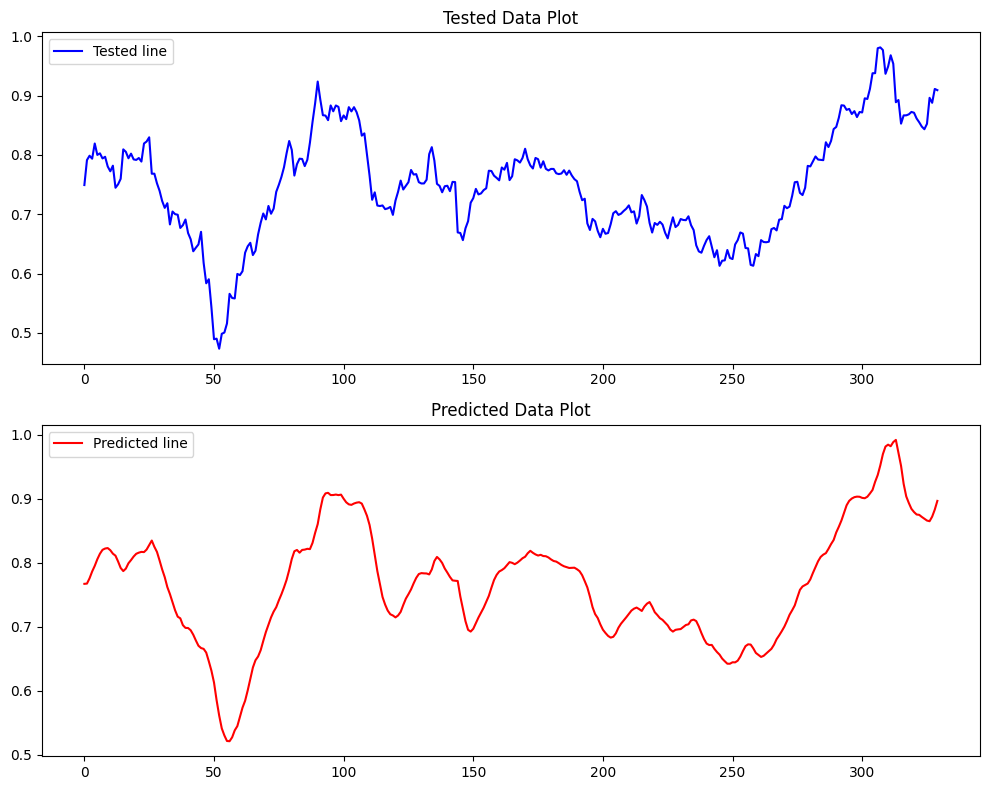

In [23]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(y_test, color='blue', label='Tested line')
ax1.legend()
ax1.set_title('Tested Data Plot')

ax2.plot(y_pred, color='red', label='Predicted line')
ax2.legend()
ax2.set_title('Predicted Data Plot')

plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import r2_score

# Make predictions using the trained LSTM model
predictions = model.predict(X_test)

# Calculate R^2 score
r2 = r2_score(y_test, predictions)
print("R^2 Score:", r2)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R^2 Score: 0.8511250818390885


In [20]:
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015  
Test Loss: 0.0012668351409956813
